In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})

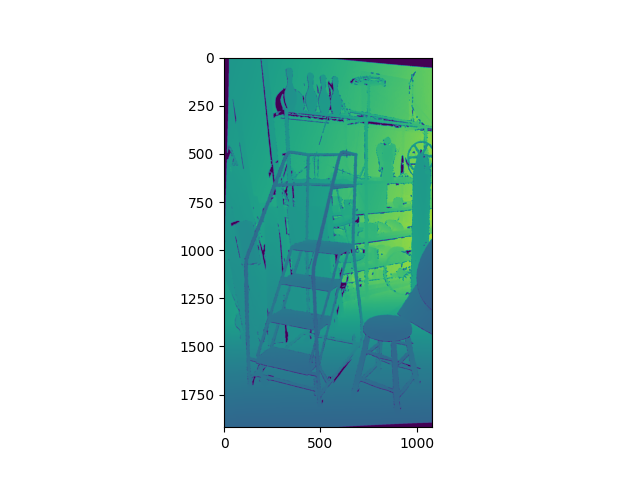

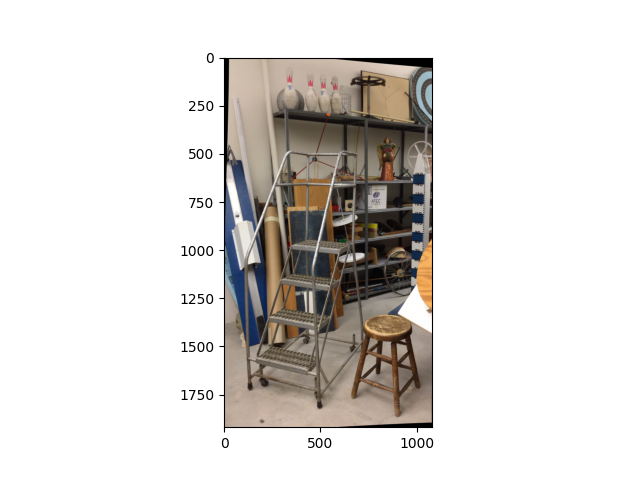

In [3]:
img_path = "~/data/middlebury/all/data/ladder1/im0.png"
dispm_path = "~/data/middlebury/all/data/ladder1/disp0.pfm"
f = 1733.68
cam = np.array([[f, 0, 819.72], [0, f, 957.55], [0, 0, 1]])
baseline=221.13
doffs=0

pfm = iio.imread(dispm_path,plugin="PFM-FI").astype(np.float32)


for y in range(pfm.shape[0]):
    for x in range(pfm.shape[1]):
        disp = pfm[y,x]
        if disp != 0:
            Z = baseline * f / (disp + doffs)
        else:
            Z = np.nan
        pfm[y,x] = Z

dm = np.flip(pfm,axis=0).copy()

im = iio.imread(img_path)
im = np.asarray(im)

plt.figure()
plt.imshow(dm)

plt.figure()
plt.imshow(im)


In [4]:
pts = []
invK = la.inv(cam)
for y in range(dm.shape[0]):
    for x in range(dm.shape[1]):
        dist = dm[y,x]
        pt = dist * (invK @ [x,y,1])
        pts.append(pt)

pts = np.array(pts)

In [7]:
#mesh['colors'] = my_rgb_array
#mesh.plot(scalars='colors', rgb=True, notebook=False)

mesh = pv.PolyData(pts)
mesh['colors'] = np.reshape(im,(-1,3))

#mesh.plot(scalars='colors',rgb=True, render_points_as_spheres=True,eye_dome_lighting=True,notebook=False)
mesh.plot(scalars='colors',rgb=True,notebook=False, point_size=1,eye_dome_lighting=True)

In [9]:
from src.dmcpworkflow.annotate_points import annotate

mpl.use("QT5Agg")
cps = annotate(im[:,:,0],dm) # exactly nonplanar 6 do seem best
%matplotlib inline
print(cps)

[[    329.14      79.95     339.40      85.08]
 [    577.98     105.60     583.11     120.99]
 [    896.08    1606.32     890.95    1593.50]
 [    462.54    1095.82     470.24    1106.08]]


In [10]:
#cps[:,2:] = cps[:,:2]

In [11]:
#cps = np.array([[ 340.53626943,  498.71808761,  340.53626943,  498.71808761],
#       [ 441.31010699,  514.22175493,  441.31010699,  514.22175493],
#       [ 689.36878407,  506.46992127,  689.36878407,  506.46992127],
#       [ 619.60228114,  496.13414306,  619.60228114,  496.13414306],
#       [ 131.23676065, 1568.47113249,  131.23676065, 1568.47113249],
#       [ 492.98899805, 1661.4931364 ,  492.98899805, 1661.4931364 ],
#       [ 418.05460602, 1436.6899603 ,  418.05460602, 1436.6899603 ],
#       [ 715.20822959, 1488.36885136,  715.20822959, 1488.36885136]])

#cps = np.array([[    702.29,    1677.00   ,  704.87  ,  1679.58],
# [    898.67  ,  1757.10   ,  898.67 ,   1754.52],
# [   1002.03,    1674.41 ,    994.27  ,  1664.08],
# [    968.43 ,   1540.05,     968.43  ,  1545.22],
# [    890.92 ,   1586.56,     885.75   , 1583.97],
# [    735.88 ,   1532.30   ,  738.46   , 1534.88],
# [    141.57 ,    863.05   ,  138.99  ,   870.81]])

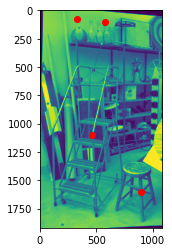

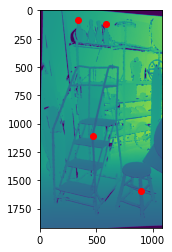

In [12]:
plt.figure()
plt.imshow(im[:,:,0])
plt.scatter(cps[:,0],cps[:,1],c="r")

plt.figure()
plt.imshow(dm,origin="upper")
plt.scatter(cps[:,2],cps[:,3],c="r")

plt.show()

In [13]:
from src.pycv.dmcp import dm_to_world
ext = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P = cam @ ext

world_pts = dm_to_world(dm, cam, P,cps[:,2:])
world_pts

array([[  -2593.72,   -4711.37,    9361.93],
       [  -1391.06,   -4918.23,   10192.55],
       [    257.62,    2300.00,    6270.13],
       [  -1202.73,     511.17,    5966.37]], dtype=float32)

In [14]:
import pyvista as pv
cps_mesh = pv.PolyData(world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True,point_size=1)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [15]:
from src.pycv.dmcp import dmcp
R  = np.array([ [ 0.6663311,  0.2944014,  0.6850771],
   [0.6567611,  0.2033320, -0.7261687],
  [-0.3530832,  0.9338008, -0.0578650 ]])
T = np.array([[100,100,-200]]).T
trans = np.hstack((R,T))
trans = np.vstack((trans,[0,0,0,1]))

P_im = P @ la.inv(trans)

#P_im = P

A = dmcp(cam, P_im, cps[:,:2],world_pts)
print(f"A\n{A}")

estimated pose
[[      1.00       0.01       0.01    -102.49]
 [     -0.01       1.00      -0.01     115.99]
 [     -0.01       0.01       1.00     215.43]]
A
[[      0.68       0.65      -0.35    -304.72]
 [      0.28       0.21       0.94     254.16]
 [      0.68      -0.73      -0.04     212.35]
 [      0.00       0.00       0.00       1.00]]


In [16]:
P_trans = P_im @ la.inv(A)

print("pose (mm)")
pos_est = la.null_space(P_trans) / la.null_space(P_trans)[-1]
pos_truth = la.null_space(P) / la.null_space(P)[-1]

pos_est = pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
pos_est 

pose (mm)


array([   -102.49,     115.99,     215.43])

dmcp works with arbitrary transformation 

In [17]:
sv_est = pv.Sphere(center=pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()

reproject points

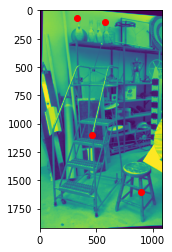

In [18]:
#P_trans @ world_pts
reprojected = P_trans @ np.hstack((world_pts,np.ones((world_pts.shape[0],1)))).T
reprojected = reprojected.T
repr0 = reprojected[:,0] / reprojected[:,-1]
repr1 = reprojected[:,1] / reprojected[:,-1]
repr = np.vstack((repr0,repr1)).T

plt.imshow(im[:,:,0])
plt.scatter(repr[:,0],repr[:,1], c="r")

#### test the same for custom depth map

In [19]:
from src.dmcpworkflow.capture_depth import generate_depth_map
import pyrender
pmesh = pyrender.Mesh.from_points(mesh.points, mesh["colors"])
tup = generate_depth_map(pmesh,cam)

[[      1.00       0.00       0.00       0.00]
 [      0.00       1.00      -0.00       0.00]
 [      0.00       0.00       1.00       0.00]]
[[      1.00       0.00       0.00]
 [      0.00      -1.00      -0.00]
 [      0.00       0.00      -1.00]]
[[      0.00]
 [      0.00]
 [      0.00]]


[[   1733.68       0.00     819.72]
 [      0.00    1733.68     957.55]
 [      0.00       0.00       1.00]]


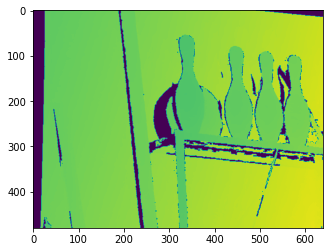

In [20]:
_dm, _dmK, _dmP = tup

print(_dmK)

plt.imshow(_dm)
plt.show()

In [22]:
from src.dmcpworkflow.annotate_points import annotate
mpl.use("QT5Agg")
_cps = annotate(im[:,:,0],_dm) # exactly nonplanar 6 do seem best
%matplotlib inline
print(_cps)

[[    338.04      78.93     337.56      72.13]
 [    450.55      99.86     448.53     100.52]
 [    518.57     118.18     513.91     114.28]
 [    583.98     120.79     581.01     116.86]
 [     60.72     222.83      52.83     222.67]
 [    327.58     283.00     325.52     284.60]]


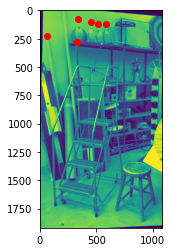

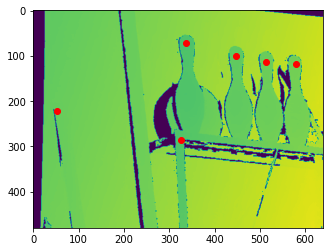

In [23]:
plt.figure()
plt.imshow(im[:,:,0])
plt.scatter(_cps[:,0],_cps[:,1],c="r")

plt.figure()
plt.imshow(_dm,origin="upper")
plt.scatter(_cps[:,2],_cps[:,3],c="r")

plt.show()

In [24]:
_world_pts = dm_to_world(_dm, _dmK, _dmP,_cps[:,2:])
_world_pts

array([[  -2597.59,   -4770.17,    9340.12],
       [  -2094.75,   -4836.56,    9783.78],
       [  -1766.06,   -4869.90,   10012.01],
       [  -1402.38,   -4938.81,   10184.86],
       [  -4384.87,   -4201.89,    9912.77],
       [  -2693.92,   -3668.31,    9450.46]], dtype=float32)

In [25]:
cps_mesh = pv.PolyData(_world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True,point_size=1)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [26]:
_A = dmcp(_dmK, P_im, _cps[:,:2],_world_pts)
print(f"A\n{_A}")

estimated pose
[[      1.00       0.01      -0.01     145.81]
 [     -0.01       1.00      -0.02     172.18]
 [      0.01       0.02       1.00       9.88]]
A
[[      0.66       0.67      -0.35     -56.01]
 [      0.28       0.21       0.94     310.79]
 [      0.70      -0.72      -0.05       2.37]
 [      0.00       0.00       0.00       1.00]]


In [27]:
_P_trans = P_im @ la.inv(_A)

print("pose (mm)")
_pos_est = la.null_space(_P_trans) / la.null_space(_P_trans)[-1]
pos_truth = la.null_space(P) / la.null_space(P)[-1]

_pos_est = _pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
_pos_est 

pose (mm)


array([    145.81,     172.19,       9.88])

In [28]:
sv_est = pv.Sphere(center=_pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True,point_size=1)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()